In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from joblib import dump
import warnings
warnings.filterwarnings('ignore')

In [7]:
weather = pd.read_csv("dataset/train_timeseries.csv")
soil = pd.read_csv("dataset/soil_data.csv")


In [8]:
weather.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN


In [9]:
soil.head()


,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,32.536382,-86.644490,63,0.0419,0.2788,0.2984,0.2497,0.1142,0.0170,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1005,31.870670,-85.405456,146,0.0158,0.1868,0.5441,0.2424,0.0106,0.0003,...,72.578804,1.828159,74.406960,3,2,1,1,1,1,1
2,1003,30.659218,-87.746067,52,0.0746,0.4370,0.4415,0.0469,0.0000,0.0000,...,59.843639,2.996914,62.840553,3,2,1,2,1,1,1
3,1007,33.015893,-87.127148,93,0.0144,0.1617,0.3714,0.3493,0.0898,0.0134,...,1.916593,0.008330,1.924924,3,2,1,1,1,1,1
4,1009,33.977448,-86.567246,198,0.0050,0.0872,0.2799,0.3576,0.1477,0.1037,...,1.891909,0.027488,1.919397,3,2,1,1,1,1,1


In [10]:
print(weather.shape, soil.shape)


(19300680, 21) (3109, 32)


In [11]:
weather.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19300680 entries, 0 to 19300679
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 3.0+ GB


In [12]:
soil.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3109 entries, 0 to 3108
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fips           3109 non-null   int64  
 1   lat            3109 non-null   float64
 2   lon            3109 non-null   float64
 3   elevation      3109 non-null   int64  
 4   slope1         3109 non-null   float64
 5   slope2         3109 non-null   float64
 6   slope3         3109 non-null   float64
 7   slope4         3109 non-null   float64
 8   slope5         3109 non-null   float64
 9   slope6         3109 non-null   float64
 10  slope7         3109 non-null   float64
 11  slope8         3109 non-null   float64
 12  aspectN        3109 non-null   float64
 13  aspectE        3109 non-null   float64
 14  aspectS        3109 non-null   float64
 15  aspectW        3109 non-null   float64
 16  aspectUnknown  3109 non-null   float64
 17  WAT_LAND       3109 non-null   float64
 18  NVG_LAND

In [13]:
weather.describe()


,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
count,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,1.930068e+07,2.756796e+06
mean,3.067038e+04,2.644145e+00,9.665578e+01,7.816178e+00,1.280146e+01,6.951072e+00,6.986916e+00,1.868141e+01,7.411665e+00,1.126974e+01,1.288900e+01,3.564013e+00,5.195993e+00,1.928879e+00,3.267113e+00,5.525151e+00,7.811798e+00,3.130077e+00,4.681721e+00,8.245298e-01
std,1.497911e+04,6.226305e+00,5.447994e+00,4.694305e+00,1.092674e+01,1.014551e+01,1.009116e+01,1.154487e+01,1.057680e+01,4.005165e+00,1.114961e+01,1.862297e+00,2.627969e+00,1.351713e+00,1.947028e+00,2.321549e+00,2.861210e+00,2.122751e+00,2.171263e+00,1.223727e+00
min,1.001000e+03,0.000000e+00,6.612000e+01,1.200000e-01,-3.734000e+01,-3.770000e+01,-3.746000e+01,-3.220000e+01,-4.596000e+01,3.000000e-02,-3.823000e+01,2.500000e-01,5.400000e-01,0.000000e+00,1.600000e-01,4.000000e-01,7.000000e-01,0.000000e+00,3.200000e-01,0.000000e+00
25%,1.904450e+04,0.000000e+00,9.584000e+01,3.780000e+00,4.450000e+00,-9.600000e-01,-9.200000e-01,1.027000e+01,-7.000000e-01,8.420000e+00,4.340000e+00,2.140000e+00,3.110000e+00,9.600000e-01,1.810000e+00,3.790000e+00,5.680000e+00,1.450000e+00,3.130000e+00,0.000000e+00
50%,2.921200e+04,1.800000e-01,9.830000e+01,6.840000e+00,1.402000e+01,7.570000e+00,7.580000e+00,2.040000e+01,8.030000e+00,1.124000e+01,1.404000e+01,3.140000e+00,4.670000e+00,1.660000e+00,2.800000e+00,5.120000e+00,7.310000e+00,2.770000e+00,4.250000e+00,0.000000e+00
75%,4.600750e+04,2.160000e+00,9.996000e+01,1.135000e+01,2.188000e+01,1.552000e+01,1.552000e+01,2.787000e+01,1.614000e+01,1.408000e+01,2.207000e+01,4.600000e+00,6.750000e+00,2.580000e+00,4.250000e+00,6.880000e+00,9.460000e+00,4.410000e+00,5.770000e+00,1.189600e+00
max,5.604300e+04,2.345900e+02,1.043200e+02,2.292000e+01,4.139000e+01,2.755000e+01,2.755000e+01,4.991000e+01,3.380000e+01,3.461000e+01,4.385000e+01,2.369000e+01,3.628000e+01,1.720000e+01,2.825000e+01,2.835000e+01,4.273000e+01,2.087000e+01,3.243000e+01,5.000000e+00


In [14]:
soil.describe()

,fips,lat,lon,elevation,slope1,slope2,slope3,slope4,slope5,slope6,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
count,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.00000,3109.000000,3109.000000,3109.000000,3109.000000,...,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.000000,3109.00000,3109.000000,3109.000000,3109.000000
mean,30678.538437,38.280052,-91.659790,427.624638,0.054973,0.29775,0.319991,0.155878,0.053409,0.065323,...,28.494804,3.504682,31.999486,1.830492,1.553554,1.282084,1.35735,1.146993,1.135092,1.284979
std,14986.018730,4.838634,11.485291,500.158880,0.089873,0.21595,0.167727,0.128400,0.073107,0.125526,...,31.839502,10.290893,33.099657,1.192219,1.021382,1.002508,1.03011,0.922308,0.914502,1.017465
min,1001.000000,25.601043,-124.211407,-1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,19045.000000,34.686818,-98.046842,132.000000,0.008300,0.10510,0.185800,0.040800,0.000500,0.000000,...,0.143526,0.045909,1.602227,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
50%,29213.000000,38.328061,-90.181170,272.000000,0.028300,0.27100,0.347100,0.127500,0.012200,0.000700,...,14.043937,0.276606,18.811279,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000
75%,46009.000000,41.703590,-83.373303,483.000000,0.068500,0.47750,0.459300,0.255200,0.090300,0.054100,...,51.737080,1.370315,60.637421,3.000000,2.000000,1.000000,1.00000,1.000000,1.000000,1.000000
max,56045.000000,48.842653,-67.609354,3561.000000,0.974000,0.75990,0.696900,0.571700,0.330000,0.606800,...,97.029572,99.956841,99.956841,7.000000,7.000000,7.000000,7.00000,7.000000,7.000000,7.000000


In [15]:
weather['score'].value_counts()


score
0.0000    1480827
1.0000     219135
2.0000     123789
3.0000      82801
4.0000      45841
           ...   
0.1734          1
0.4052          1
1.5706          1
1.5485          1
3.0717          1
Name: count, Length: 55395, dtype: int64

In [16]:
weather['score'].isna().sum()

np.int64(16543884)

In [17]:
weather = weather.dropna(subset=['score'])

In [18]:
weather['date'] = pd.to_datetime(weather['date'])
weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month
weather['day'] = weather['date'].dt.day

In [19]:
merged_data = pd.merge(weather, soil, how='left', on='fips')
print("Merged shape:", merged_data.shape)


Merged shape: (2756796, 55)


In [20]:
merged_data['score'] = merged_data['score'].astype(int)  


In [21]:
merged_data.info()
merged_data.describe()
merged_data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756796 entries, 0 to 2756795
Data columns (total 55 columns):
 #   Column         Dtype         
---  ------         -----         
 0   fips           int64         
 1   date           datetime64[ns]
 2   PRECTOT        float64       
 3   PS             float64       
 4   QV2M           float64       
 5   T2M            float64       
 6   T2MDEW         float64       
 7   T2MWET         float64       
 8   T2M_MAX        float64       
 9   T2M_MIN        float64       
 10  T2M_RANGE      float64       
 11  TS             float64       
 12  WS10M          float64       
 13  WS10M_MAX      float64       
 14  WS10M_MIN      float64       
 15  WS10M_RANGE    float64       
 16  WS50M          float64       
 17  WS50M_MAX      float64       
 18  WS50M_MIN      float64       
 19  WS50M_RANGE    float64       
 20  score          int64         
 21  year           int32         
 22  month          int32         
 23  day    

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,CULTRF_LAND,CULTIR_LAND,CULT_LAND,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7
0,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
1,1001,2000-01-11,1.33,100.40,6.63,11.48,7.84,7.84,18.88,5.72,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
2,1001,2000-01-18,1.11,100.39,9.53,14.28,13.26,13.26,18.04,8.98,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
3,1001,2000-01-25,0.00,100.11,2.05,-0.78,-7.93,-7.72,5.65,-5.46,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2
4,1001,2000-02-01,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,-4.21,...,56.293411,1.014811,57.308224,1,1,1,1,1,1,2


In [22]:
!pip install missingno

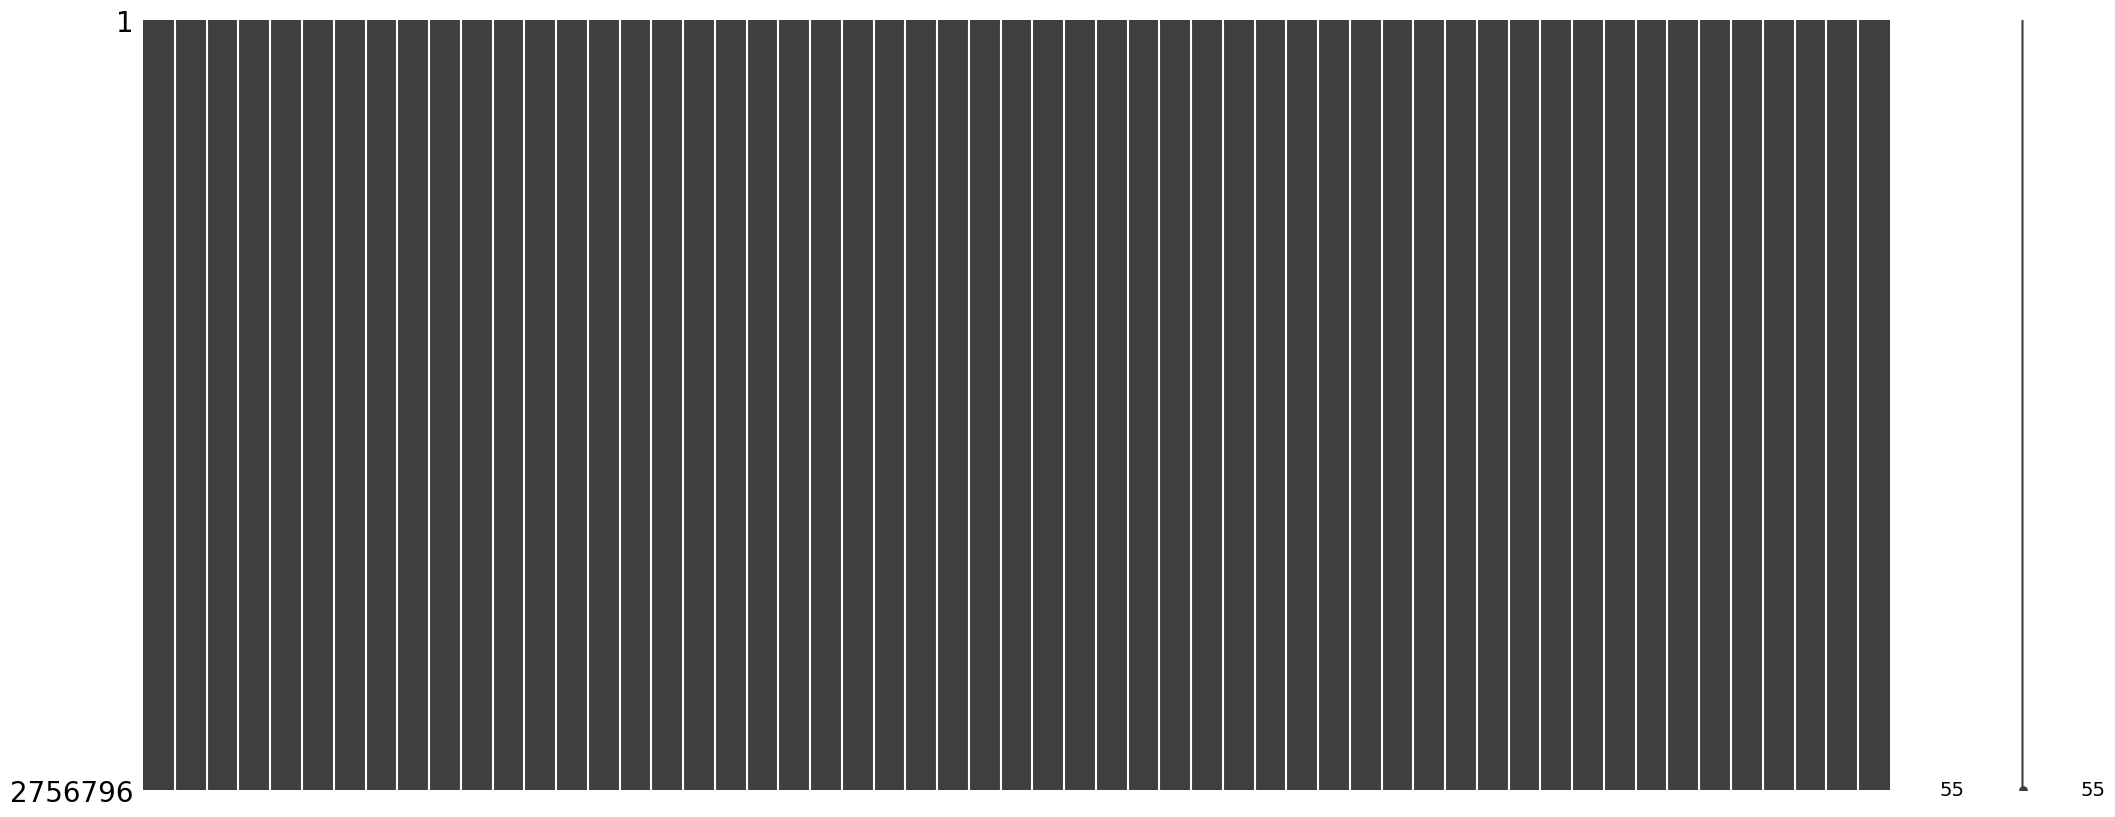

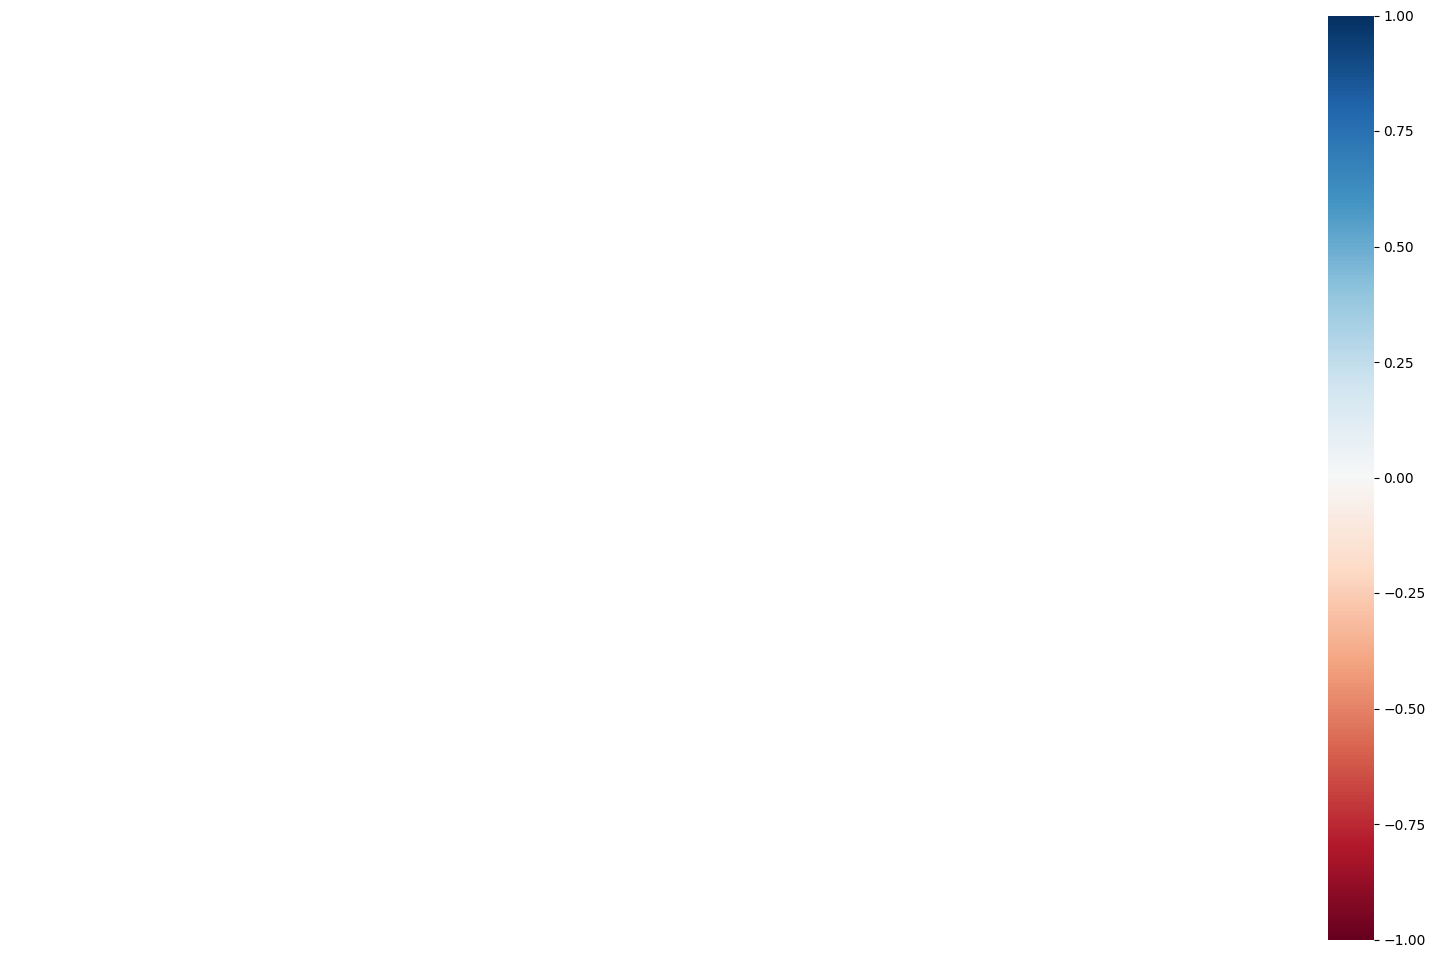

fips             0
date             0
PRECTOT          0
PS               0
QV2M             0
T2M              0
T2MDEW           0
T2MWET           0
T2M_MAX          0
T2M_MIN          0
T2M_RANGE        0
TS               0
WS10M            0
WS10M_MAX        0
WS10M_MIN        0
WS10M_RANGE      0
WS50M            0
WS50M_MAX        0
WS50M_MIN        0
WS50M_RANGE      0
score            0
year             0
month            0
day              0
lat              0
lon              0
elevation        0
slope1           0
slope2           0
slope3           0
slope4           0
slope5           0
slope6           0
slope7           0
slope8           0
aspectN          0
aspectE          0
aspectS          0
aspectW          0
aspectUnknown    0
WAT_LAND         0
NVG_LAND         0
URB_LAND         0
GRS_LAND         0
FOR_LAND         0
CULTRF_LAND      0
CULTIR_LAND      0
CULT_LAND        0
SQ1              0
SQ2              0
SQ3              0
SQ4              0
SQ5         

In [23]:
import missingno as msno

msno.matrix(merged_data)
plt.show()

msno.heatmap(merged_data)
plt.show()

print(merged_data.isnull().sum())


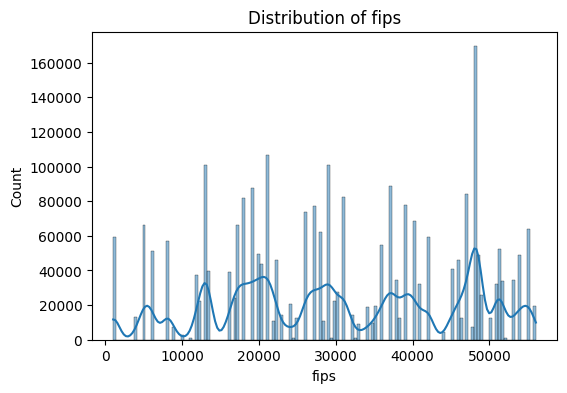

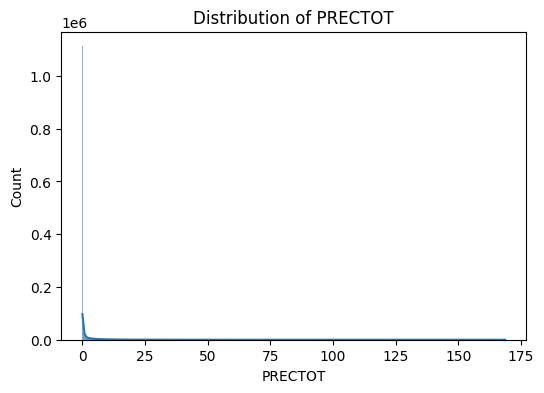

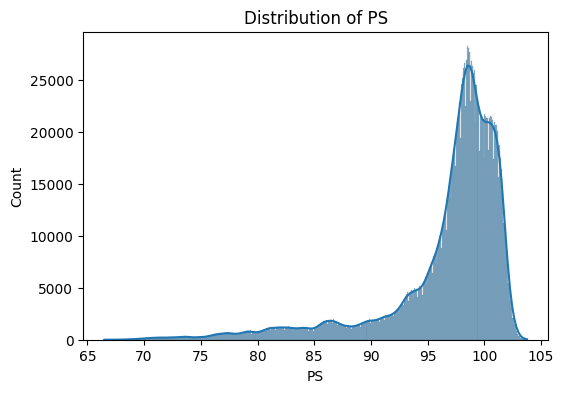

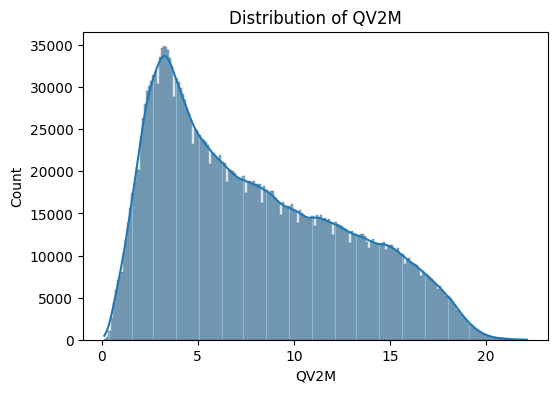

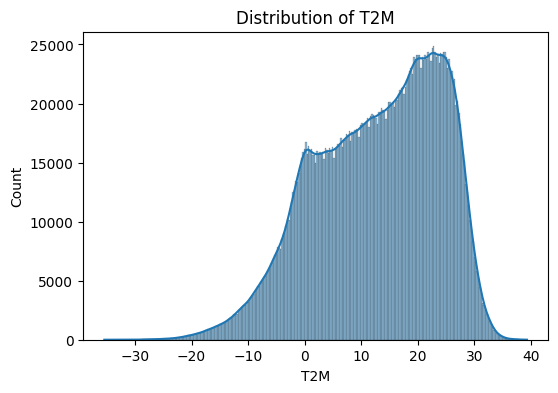

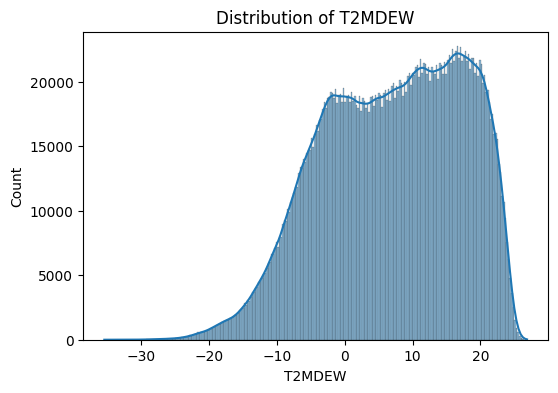

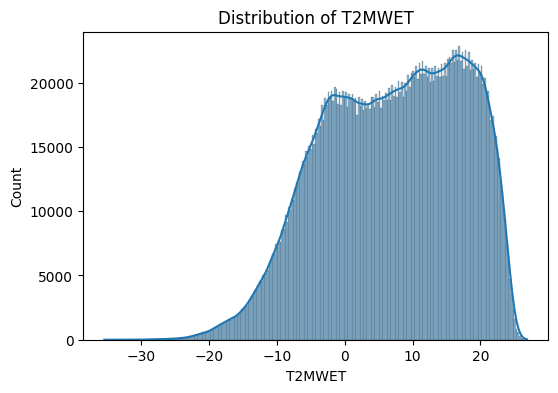

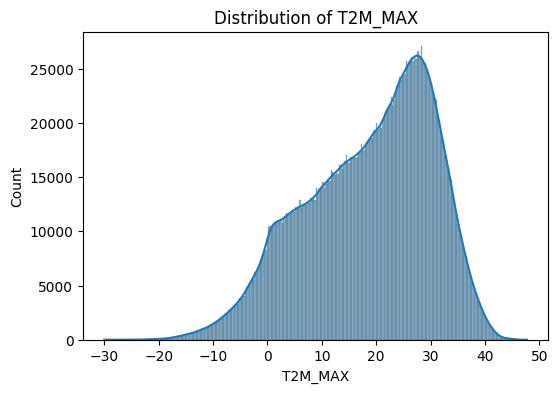

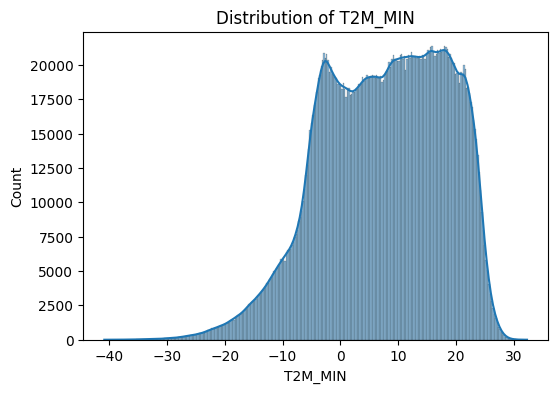

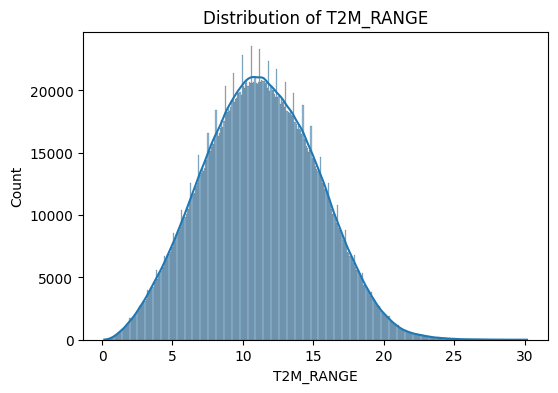

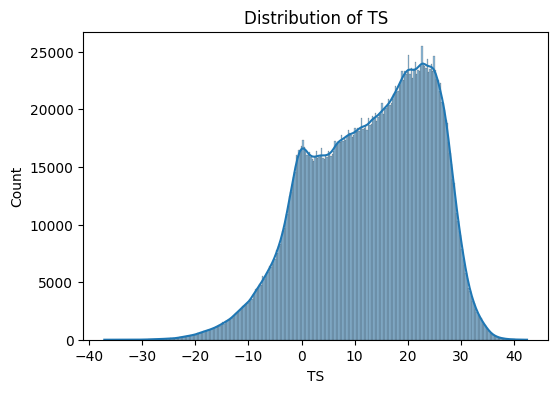

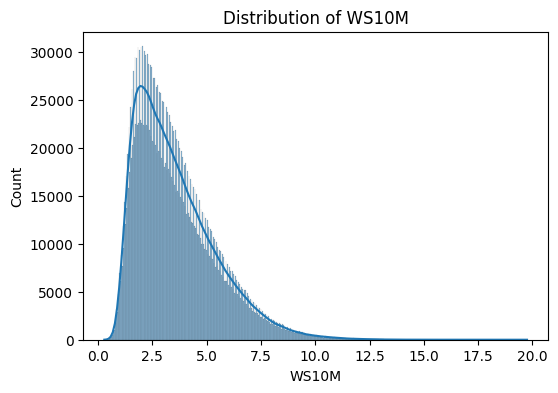

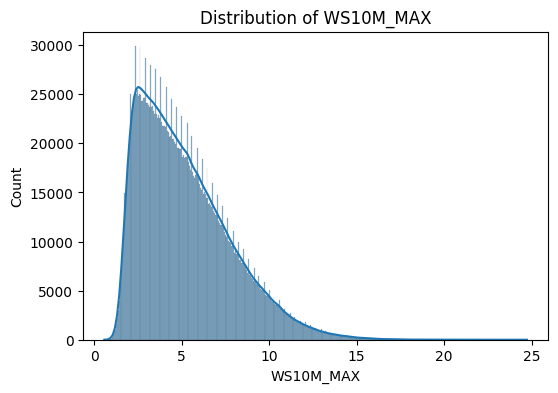

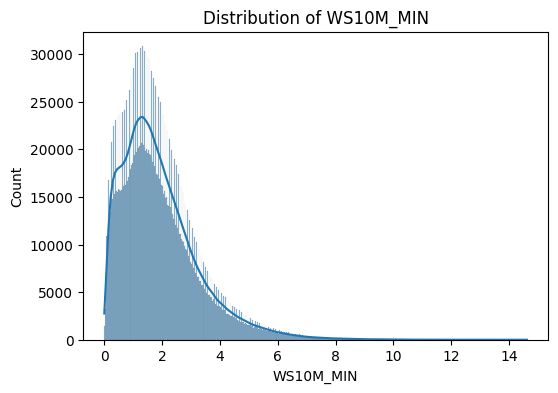

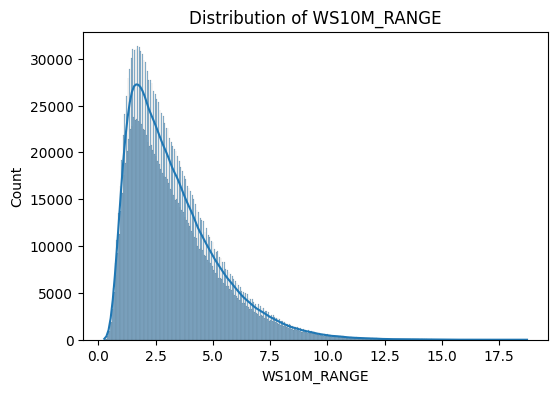

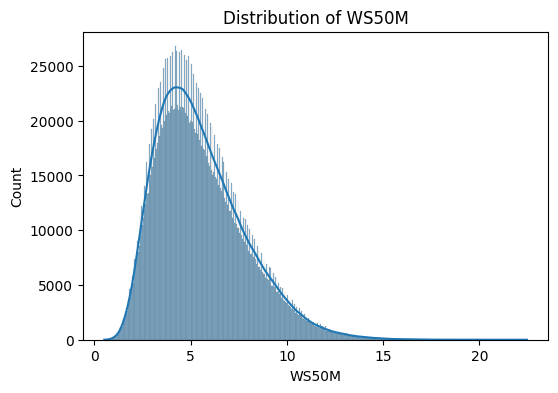

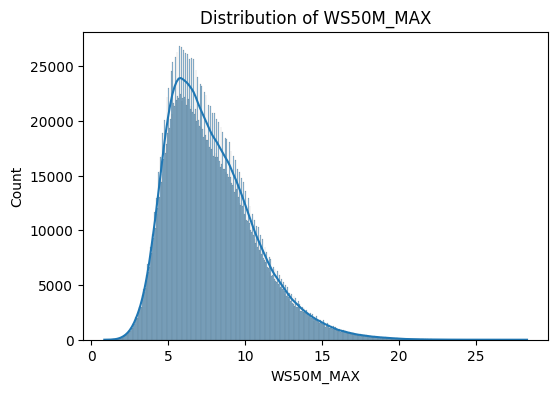

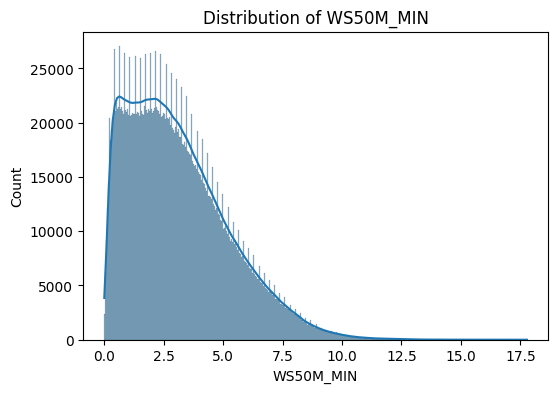

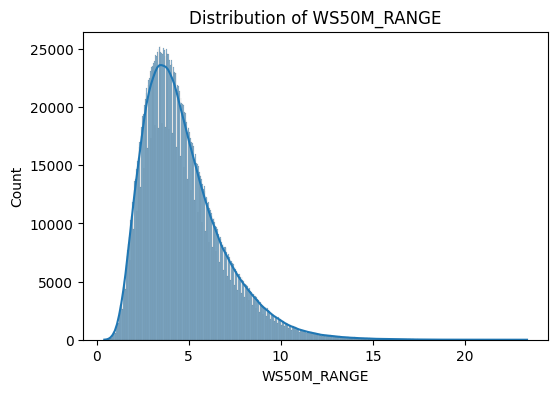

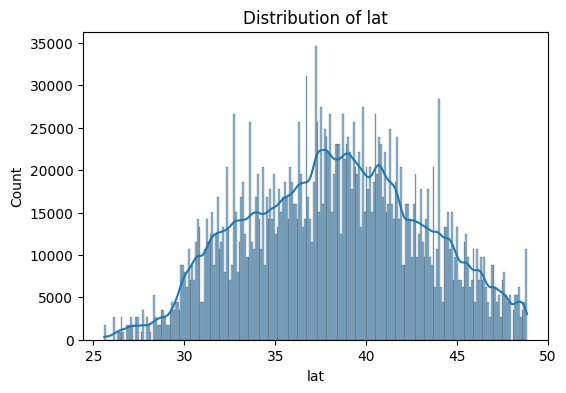

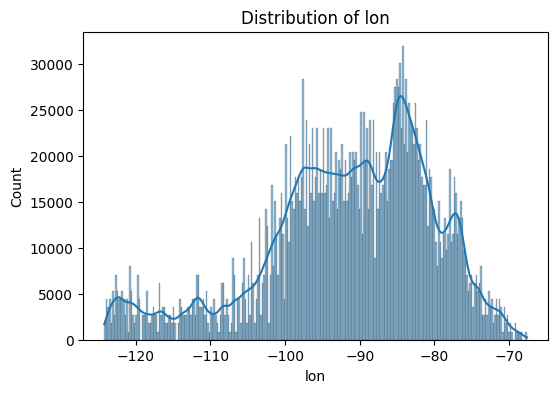

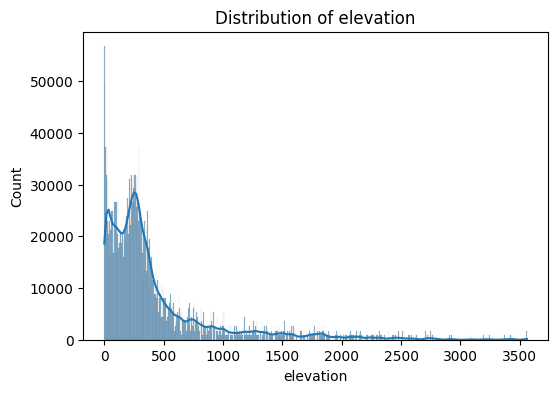

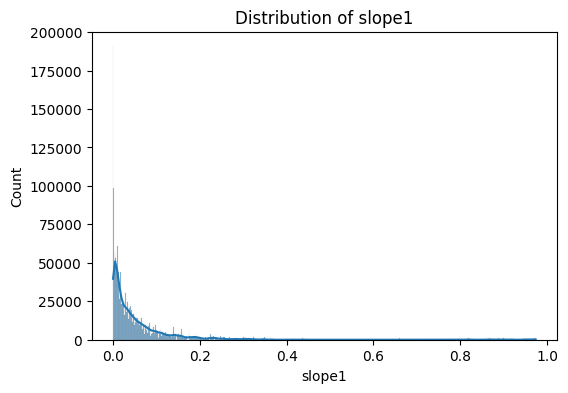

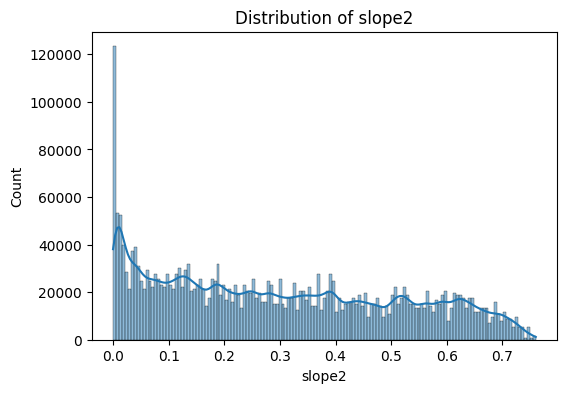

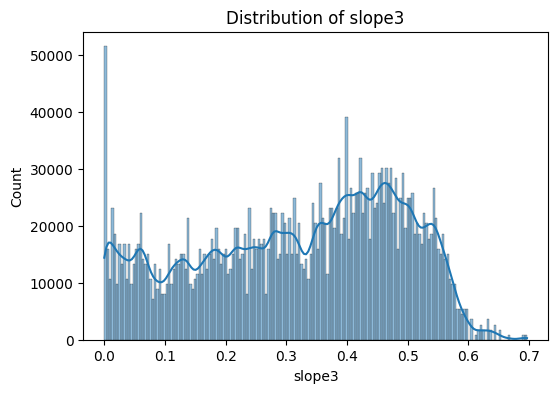

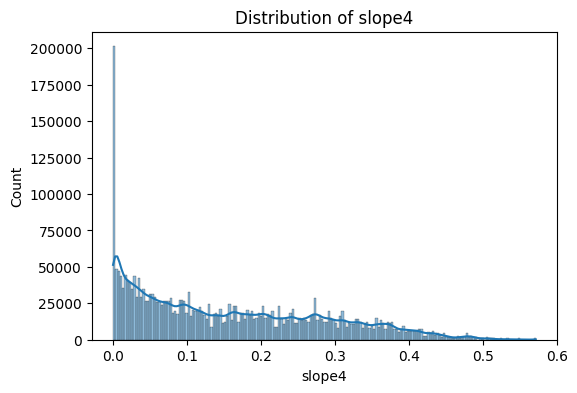

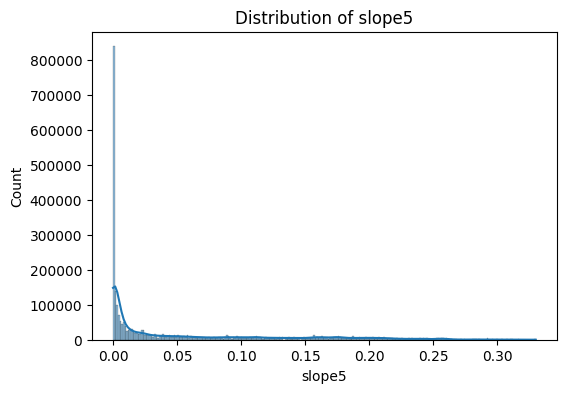

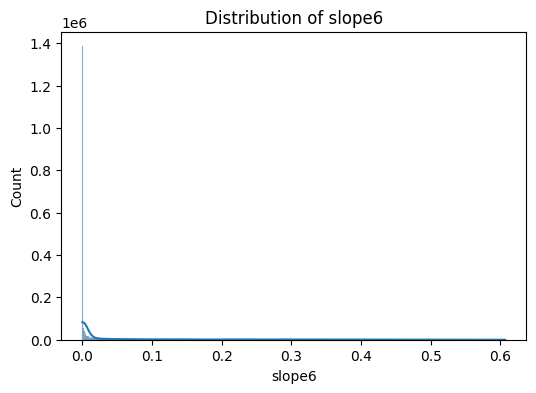

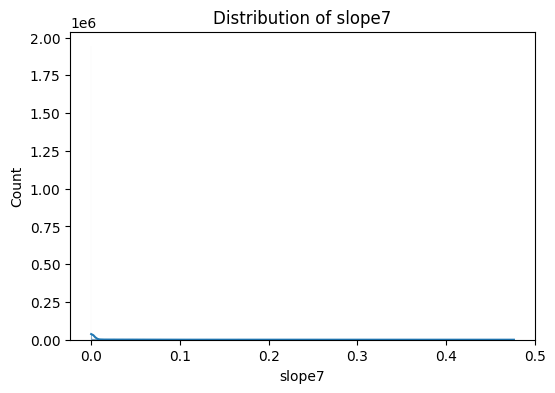

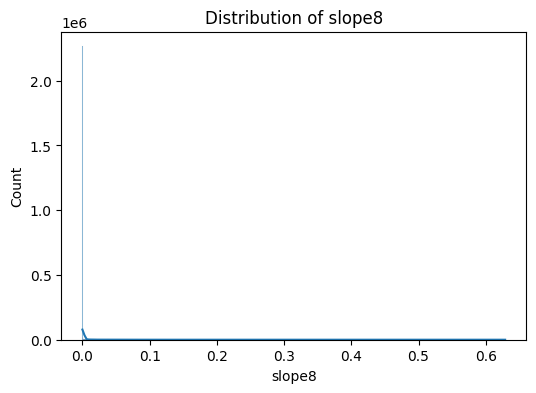

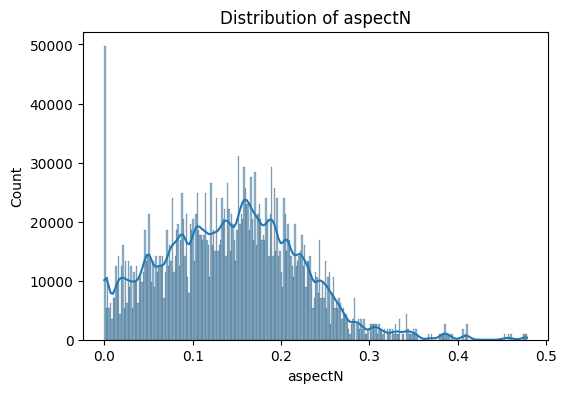

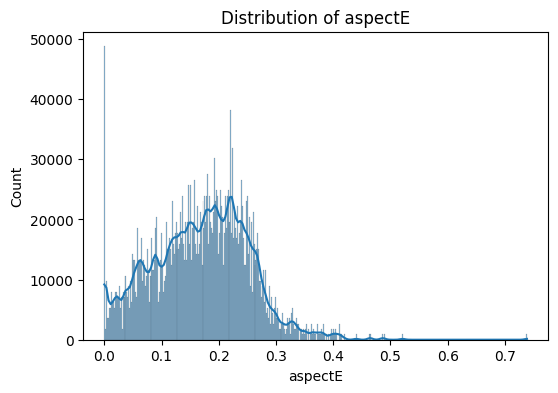

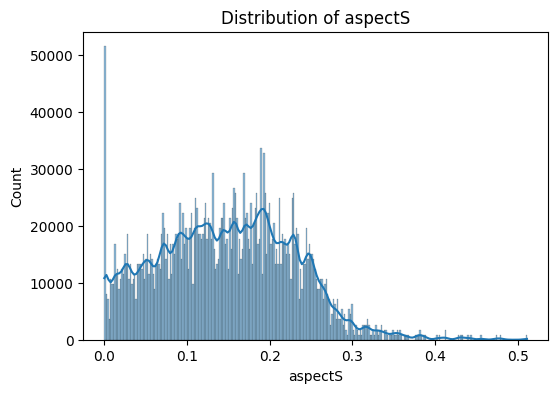

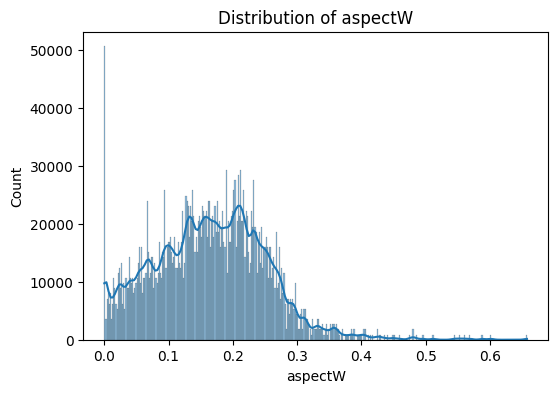

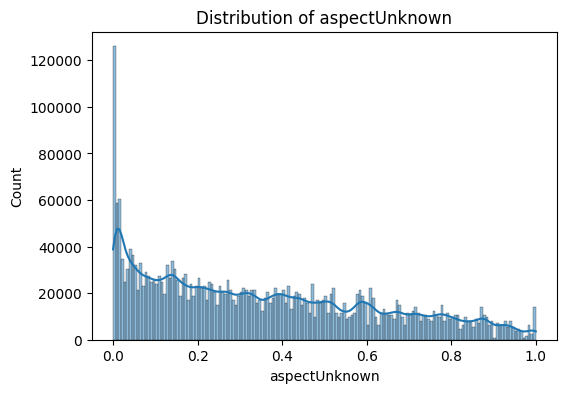

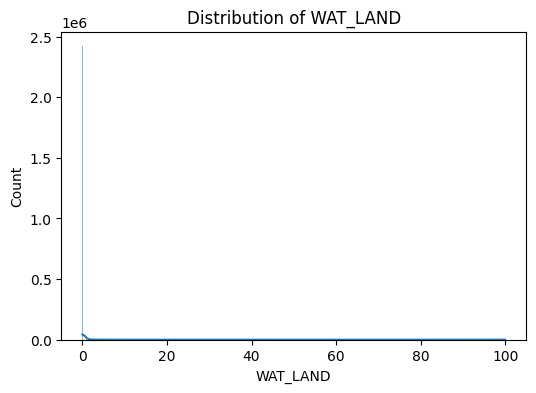

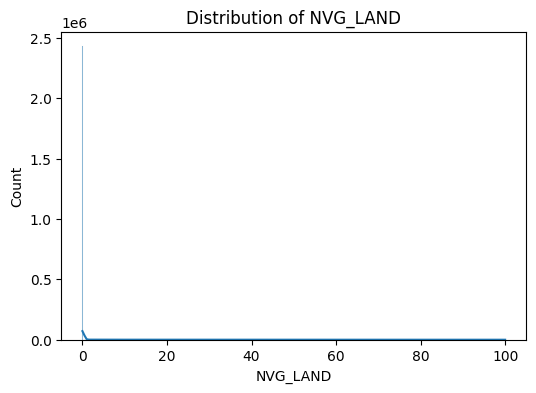

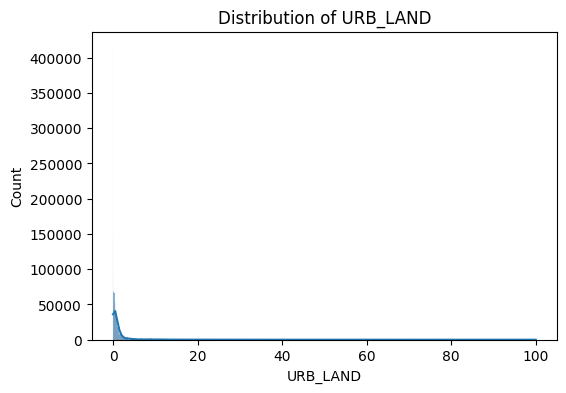

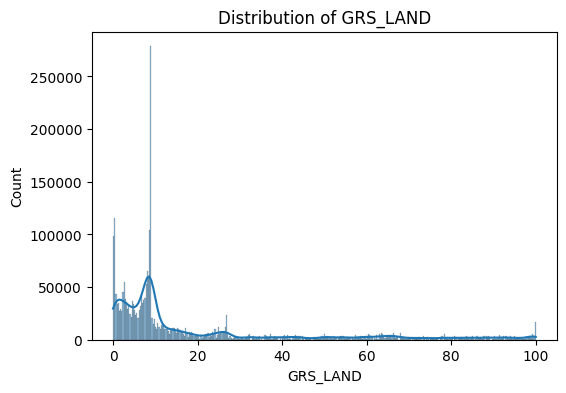

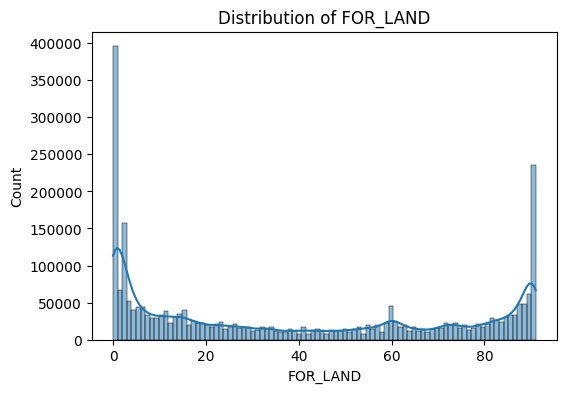

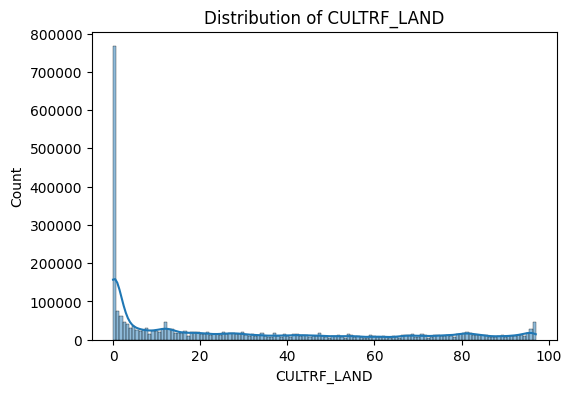

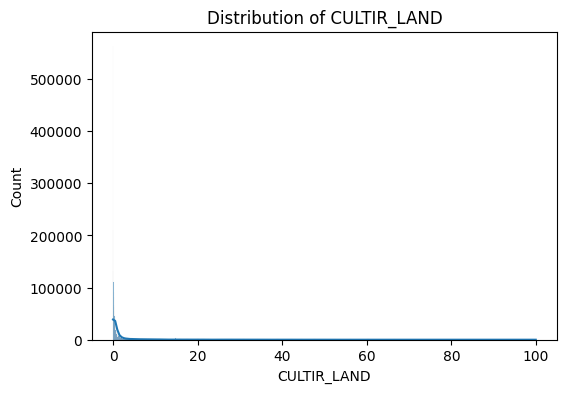

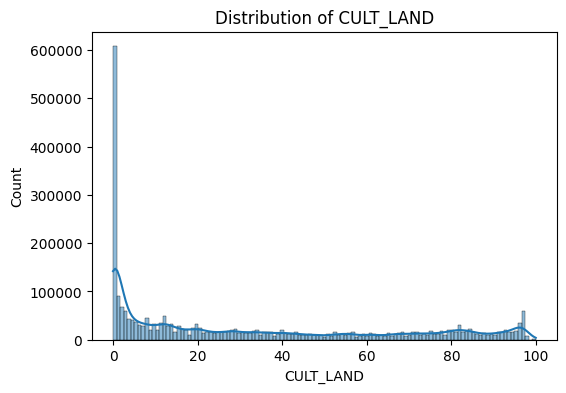

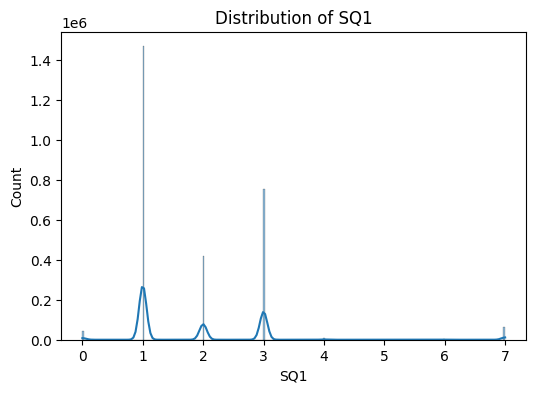

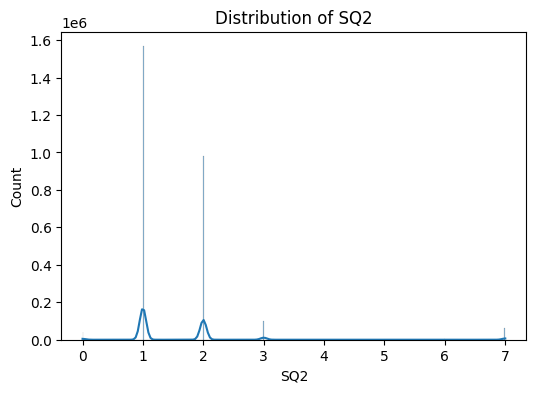

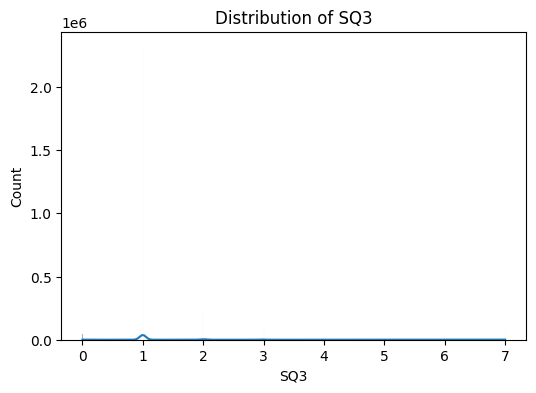

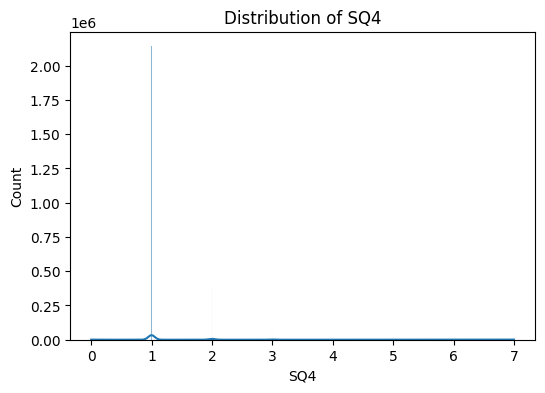

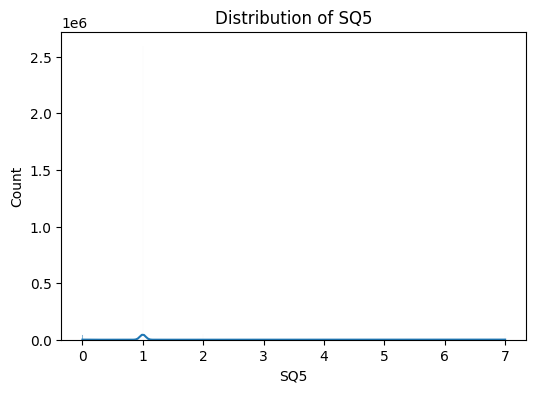

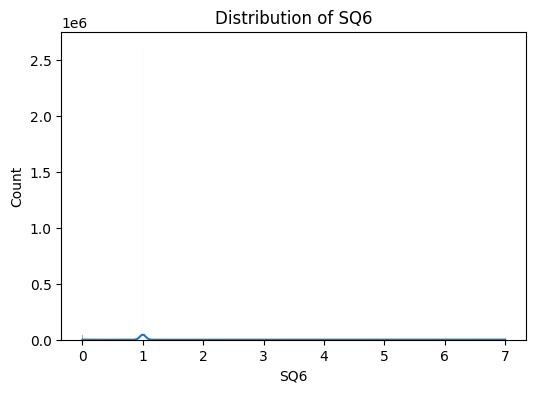

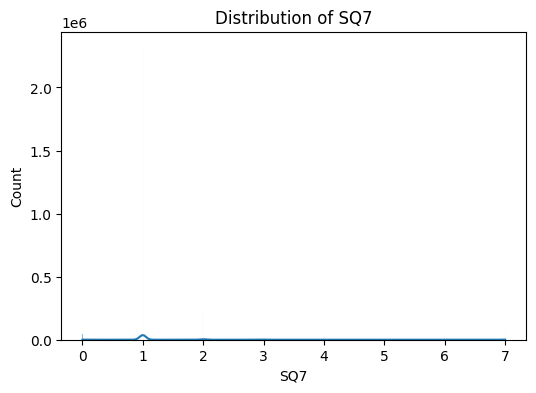

In [30]:
num_cols = merged_data.select_dtypes(include=['int64', 'float64']).columns.drop(['score'])

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(merged_data[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


In [31]:
cat_cols = merged_data.select_dtypes(include=['object']).columns

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=data)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()


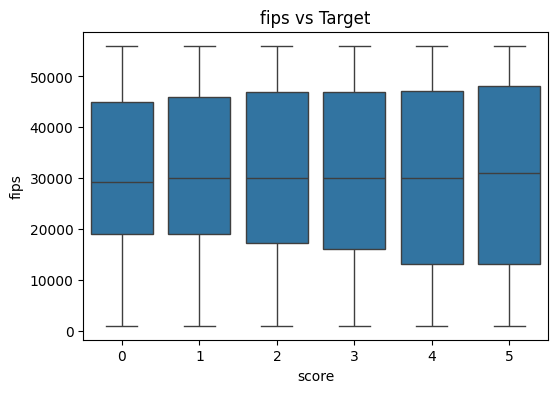

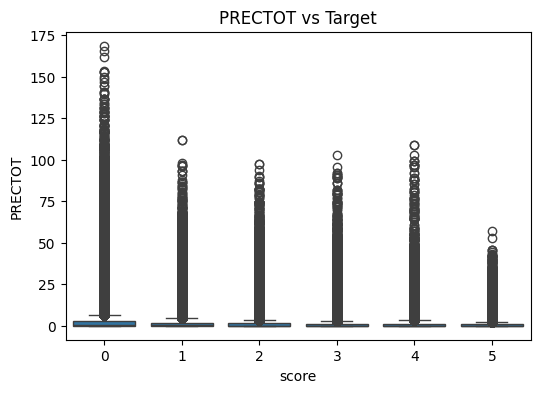

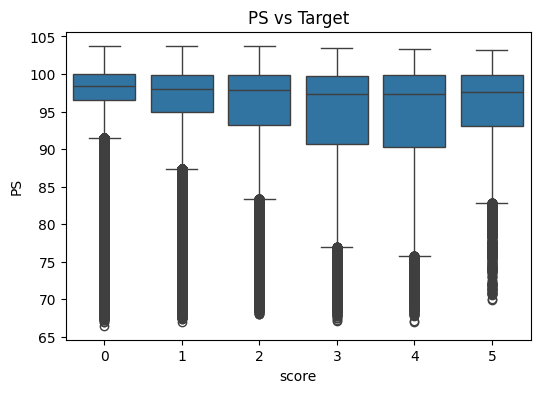

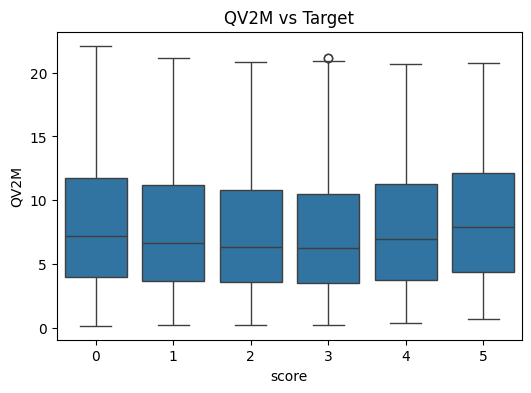

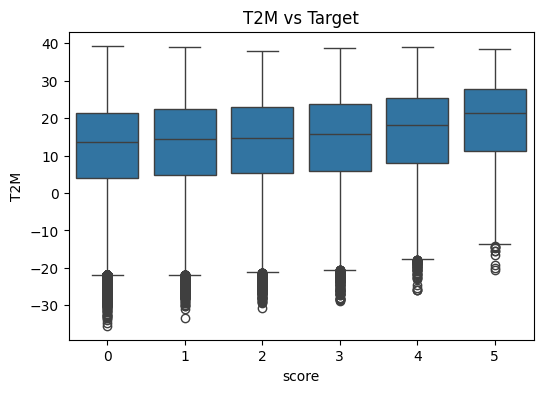

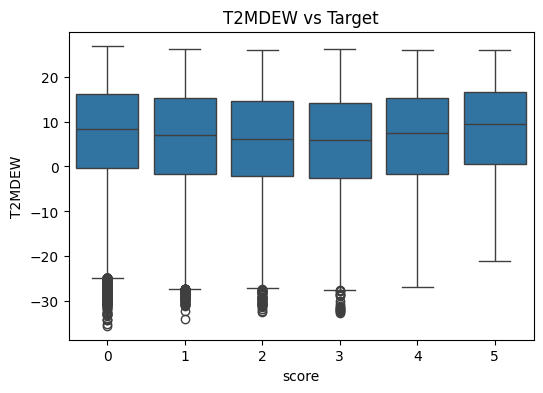

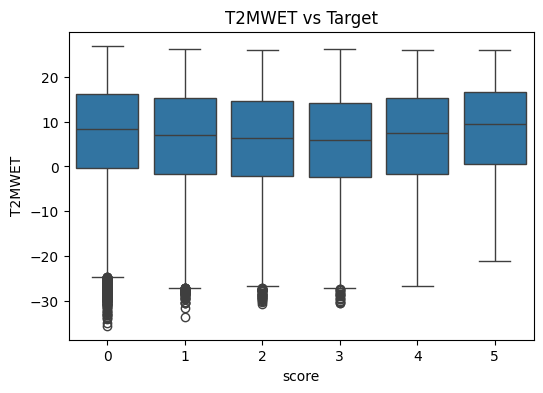

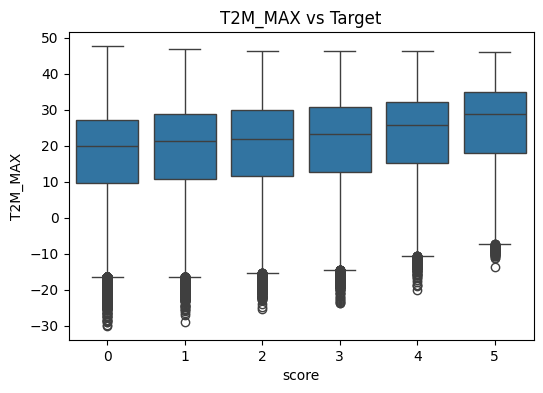

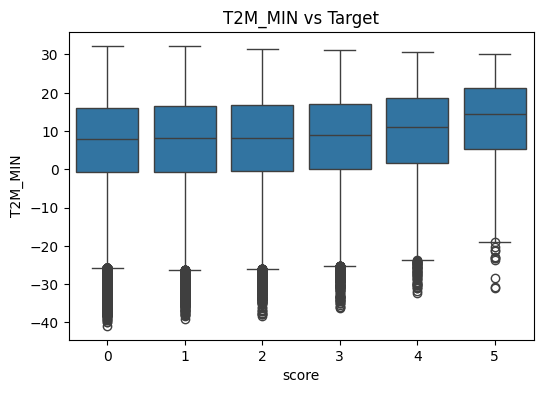

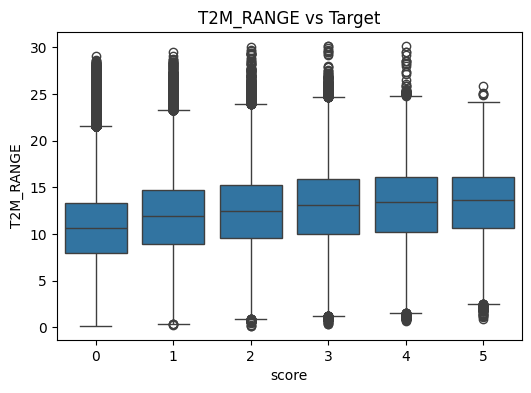

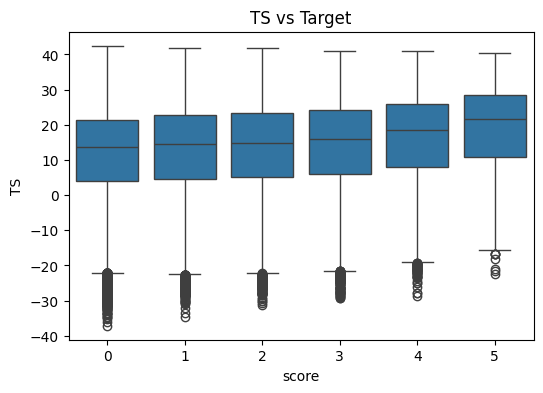

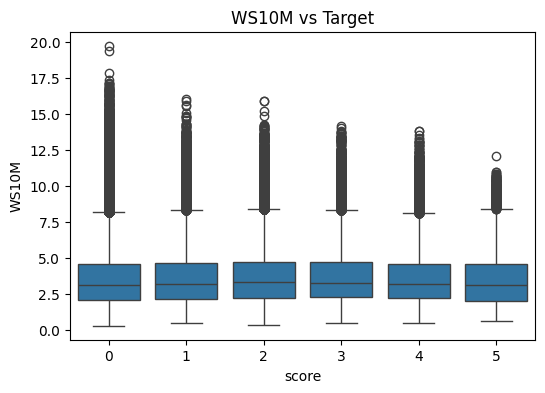

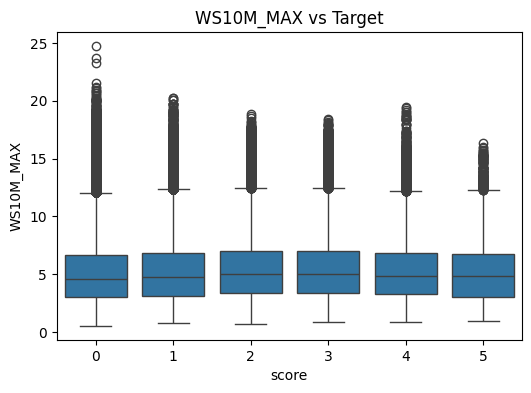

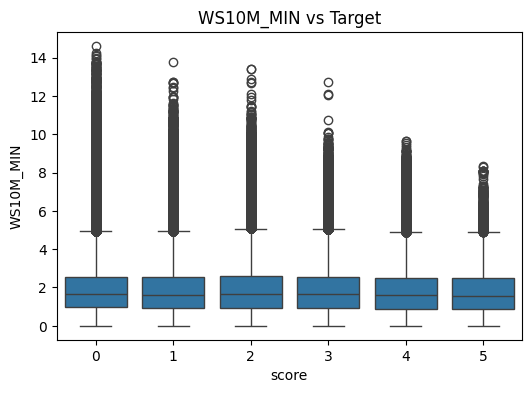

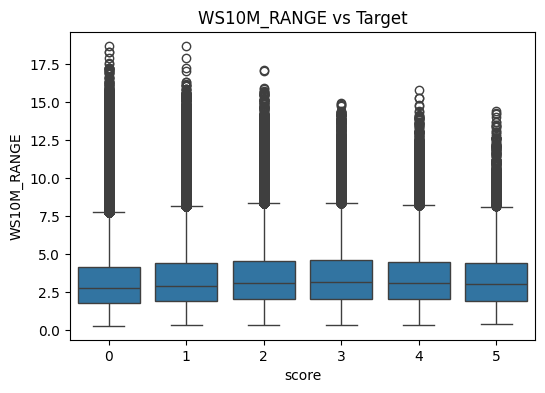

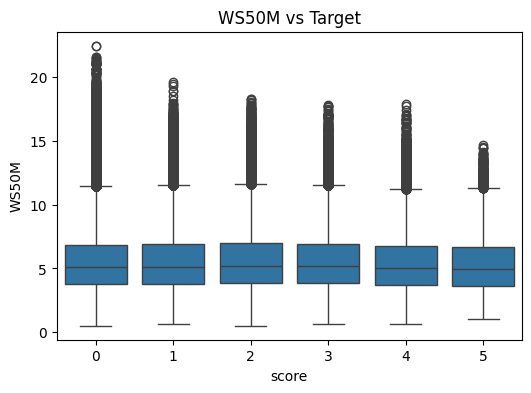

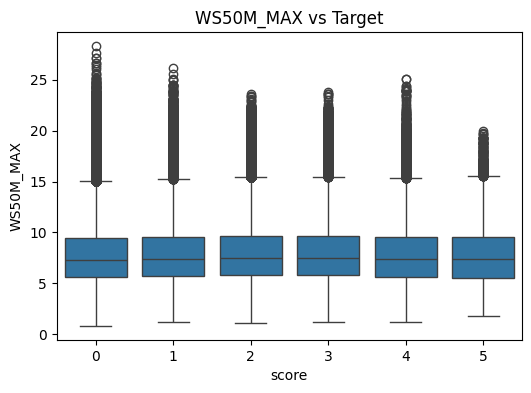

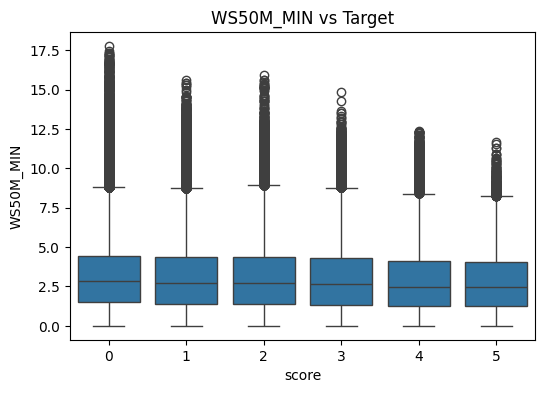

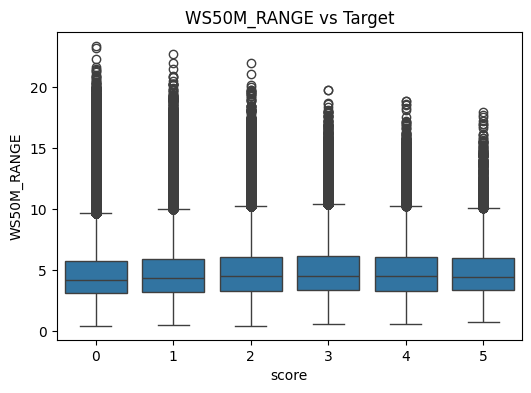

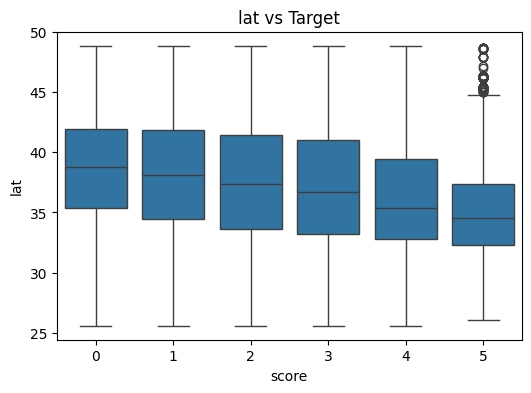

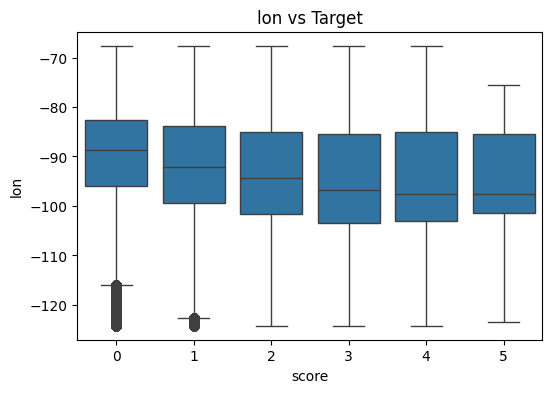

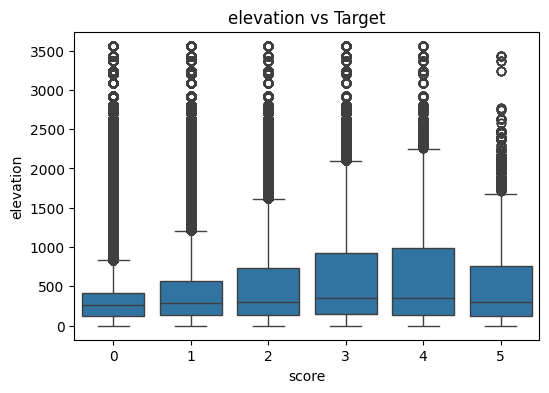

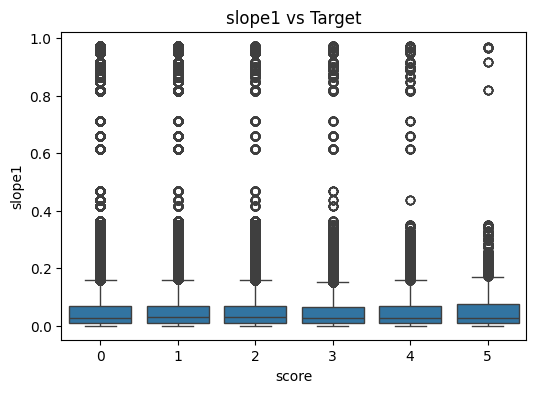

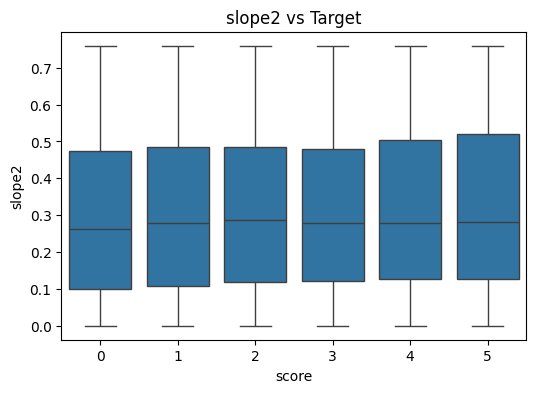

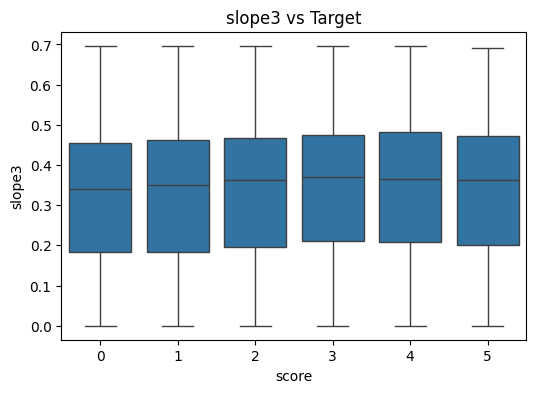

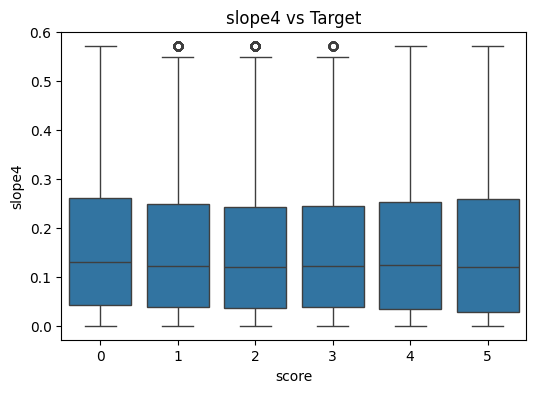

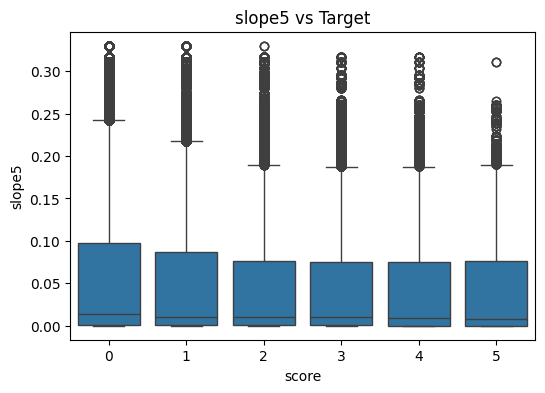

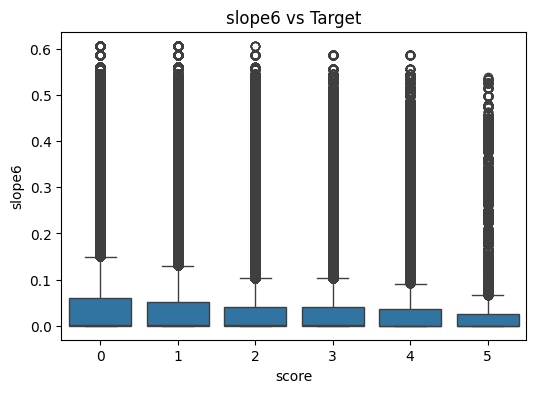

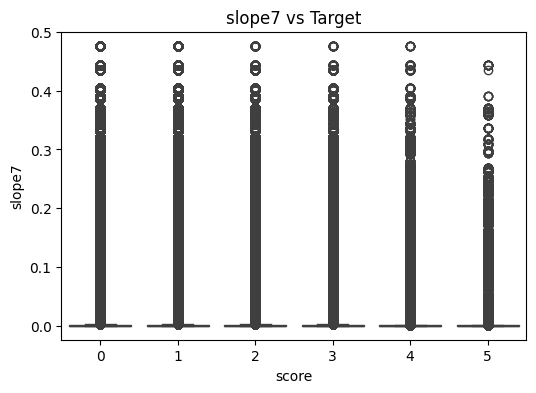

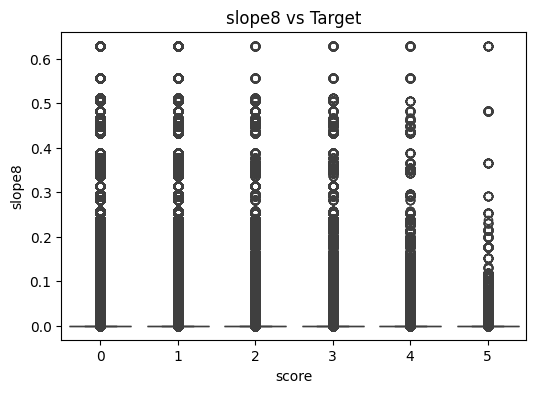

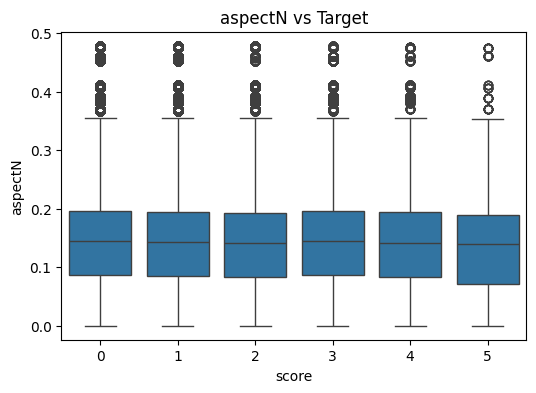

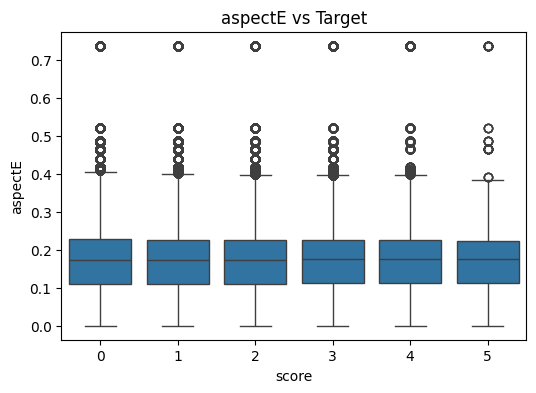

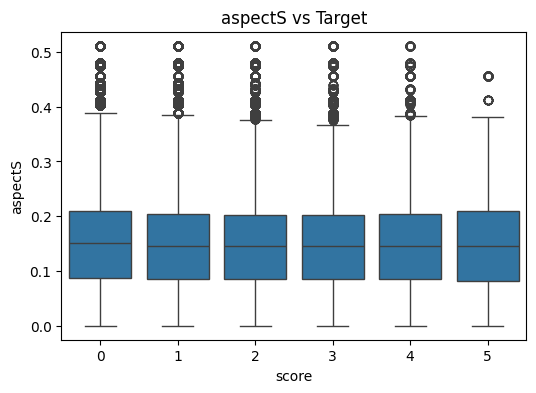

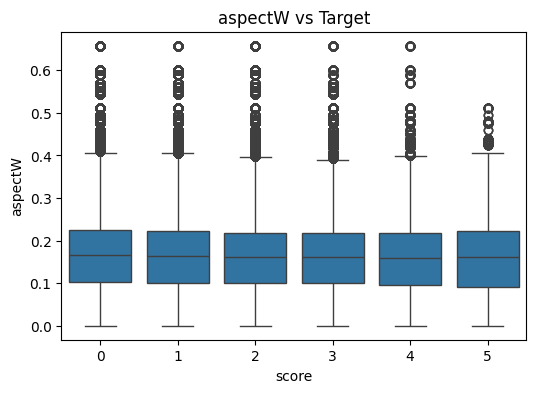

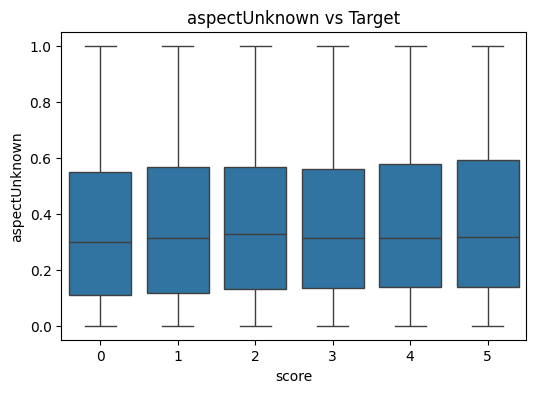

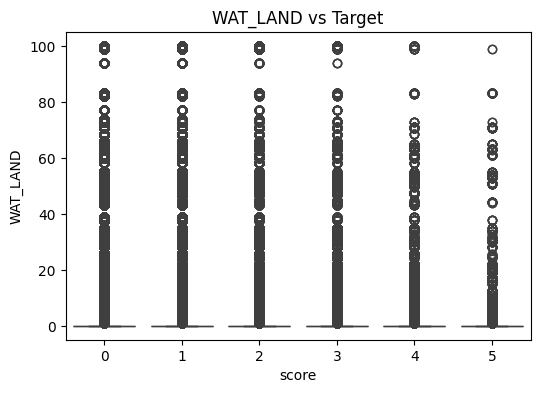

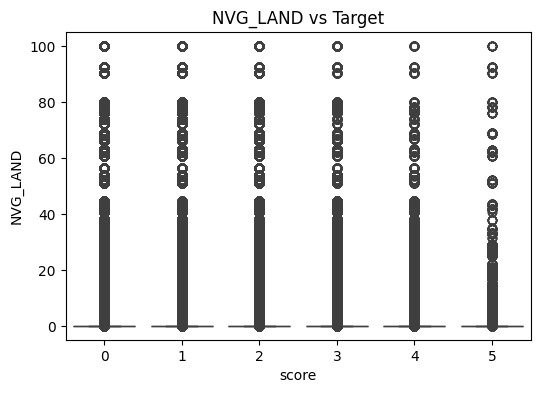

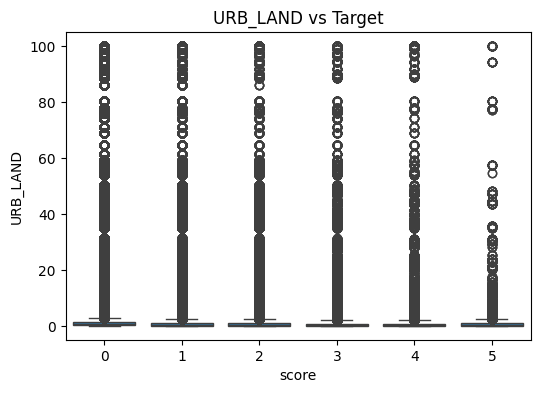

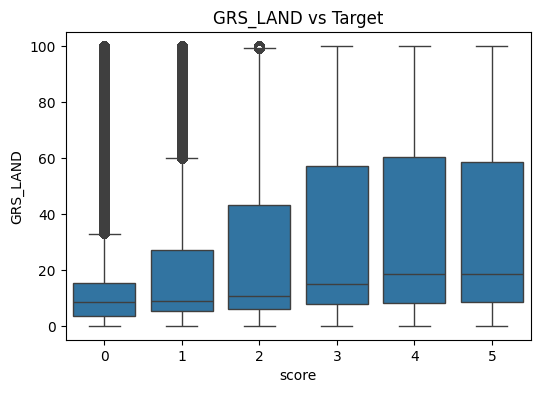

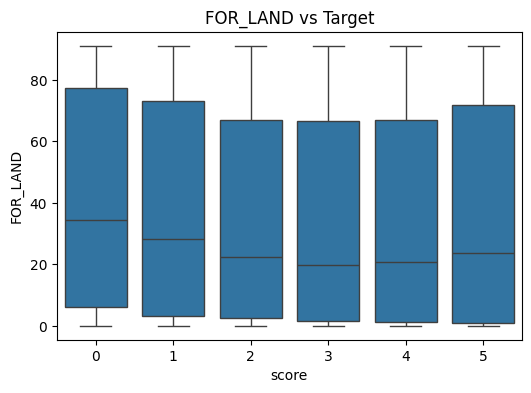

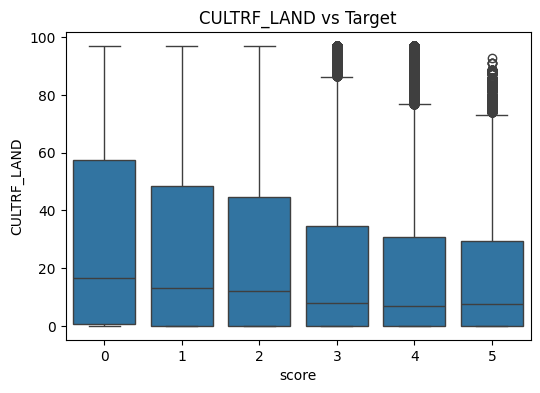

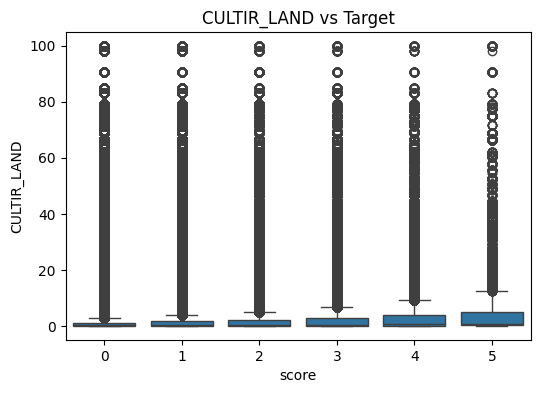

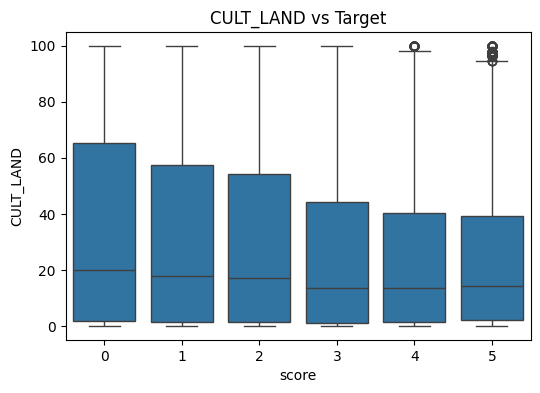

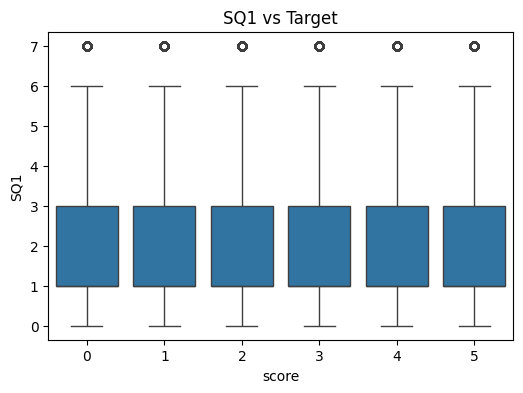

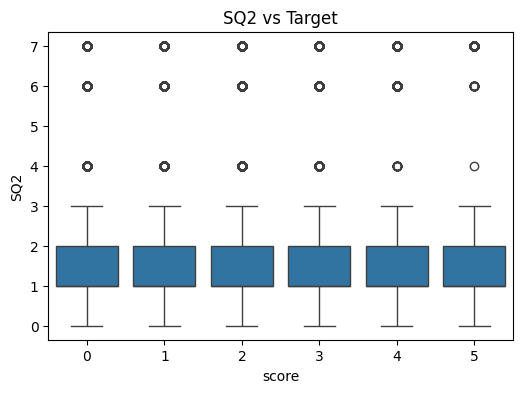

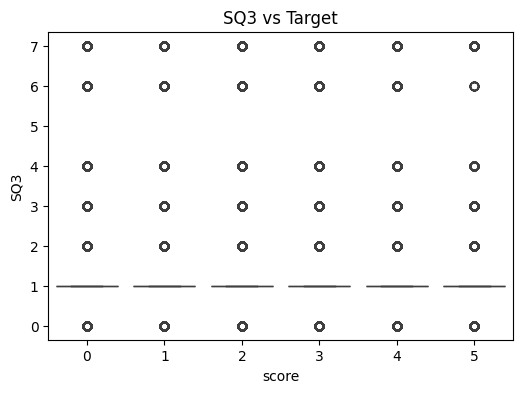

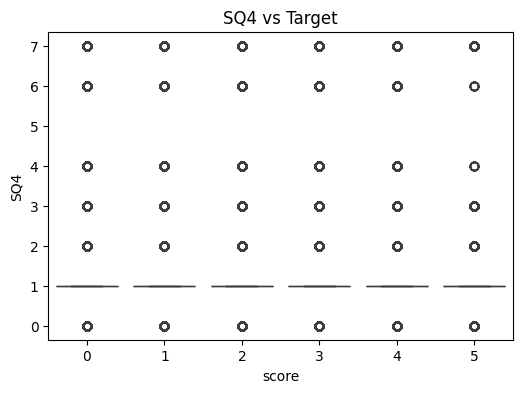

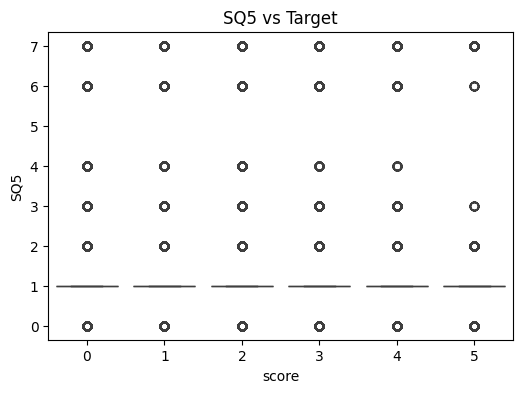

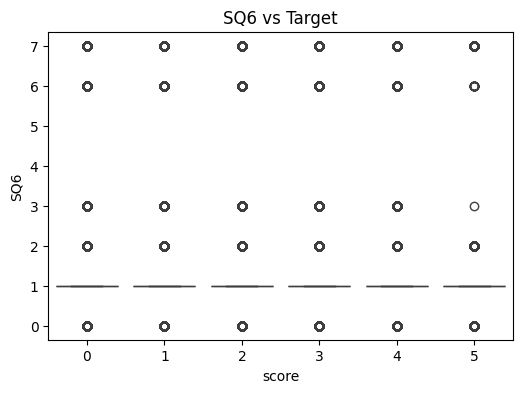

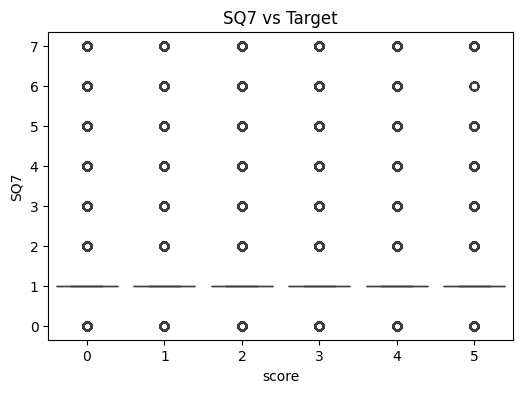

In [32]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='score', y=col, data=merged_data)
    plt.title(f"{col} vs Target")
    plt.show()

In [33]:
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue='score', data=merged_data)
    plt.title(f"{col} by Target")
    plt.xticks(rotation=45)
    plt.show()


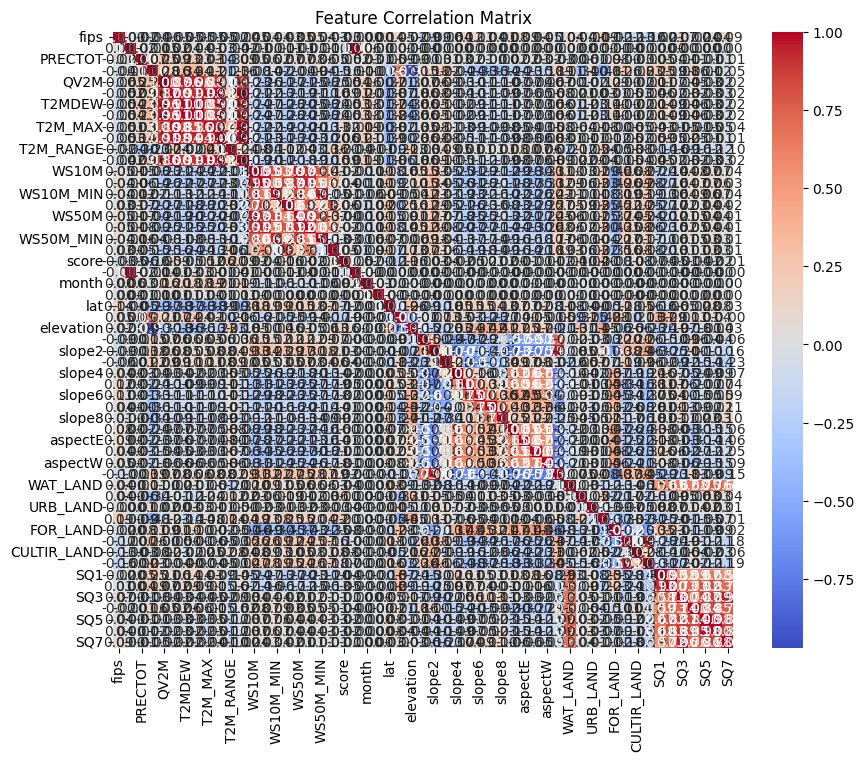

In [34]:
plt.figure(figsize=(10,8))
sns.heatmap(merged_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()


In [35]:
sns.clustermap(corr, cmap='coolwarm', annot=False, figsize=(12,12))
plt.title("Clustered Feature Correlation Matrix")
plt.show()

NameError: name 'corr' is not defined

In [26]:
X = merged_data.drop(['score', 'date', 'fips'], axis=1)
y = merged_data['score']

In [27]:
# Outlier removal (3-sigma rule)
for col in X.columns:
    upper = X[col].mean() + 3*X[col].std()
    lower = X[col].mean() - 3*X[col].std()
    X = X[(X[col] <= upper) & (X[col] >= lower)]
y = y[X.index]

In [29]:
datetime_cols = X_train.select_dtypes(include=['datetime']).columns

def extract_datetime_features(df, datetime_cols):
    df = df.copy()
    for col in datetime_cols:
        df[f'{col}_year'] = df[col].dt.year
        df[f'{col}_month'] = df[col].dt.month
        df[f'{col}_day'] = df[col].dt.day
        df[f'{col}_hour'] = df[col].dt.hour
        df[f'{col}_minute'] = df[col].dt.minute
        df[f'{col}_weekday'] = df[col].dt.weekday
    df = df.drop(columns=datetime_cols)  # Drop original datetime columns
    return df

X_train = extract_datetime_features(X_train, datetime_cols)
X_val = extract_datetime_features(X_val, datetime_cols)

NameError: name 'X_train' is not defined

In [ ]:
numeric_cols = X_train.select_dtypes(include=['number']).columns

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train[numeric_cols]),
    columns=numeric_cols, index=X_train.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val[numeric_cols]),
    columns=numeric_cols, index=X_val.index
)


NameError: name 'X_train' is not defined

In [ ]:
majority_class_count = y_train.value_counts().max()
sampling_strategy = {
    cls: majority_class_count
    for cls in y_train.unique()
    if cls != y_train.value_counts().idxmax()
}

print(f"Sampling strategy: {sampling_strategy}")
print(f"Before SMOTE: {X_train_scaled.shape}")

sm = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print(f"After SMOTE: {X_train_res.shape}")
print(y_train_res.value_counts())

NameError: name 'y_train' is not defined

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(
    n_estimators=75,          # ↓ trees
    max_depth=10,             # ↓ depth
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

clf_rf.fit(X_train_res, y_train_res)



NameError: name 'X_train_res' is not defined

In [ ]:
y_pred_rf = clf_rf.predict(X_val_scaled)

(1929616, 52)


In [ ]:
print("\n📈 Random Forest Performance:")
print(classification_report(y_val, y_pred_rf))

cm = confusion_matrix(y_val, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 1.7 MB/s eta 0:00:01
   ---------------------------- ----------- 1.0/1.5 MB 2.3 MB/s eta 0:00:01
   ---------------------------- ----------- 1.0/1.5 MB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 1.6 MB/s eta 0:00:00


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

clf_lgbm = LGBMClassifier(
    n_estimators=200,       # number of boosting rounds (trees)
    learning_rate=0.1,      # step size shrinkage
    max_depth=10,           # limits the tree depth
    random_state=42,
    class_weight='balanced', # optional: helps with imbalance
    n_jobs=-1                # use all CPU cores
)

print("🔷 Training LightGBM...")
clf_lgbm.fit(X_train_res, y_train_res)

# predict
y_pred_lgbm = clf_lgbm.predict(X_val)



🔷 Training LightGBM...



📈 LightGBM Performance:
              precision    recall  f1-score   support

           0       0.63      0.01      0.02    219904
           1       0.06      0.00      0.00     49455
           2       0.00      0.00      0.00     29599
           3       0.05      0.00      0.00     18148
           4       0.03      0.99      0.05      8948
           5       0.02      0.00      0.00      2554

    accuracy                           0.03    328608
   macro avg       0.13      0.17      0.01    328608
weighted avg       0.44      0.03      0.02    328608



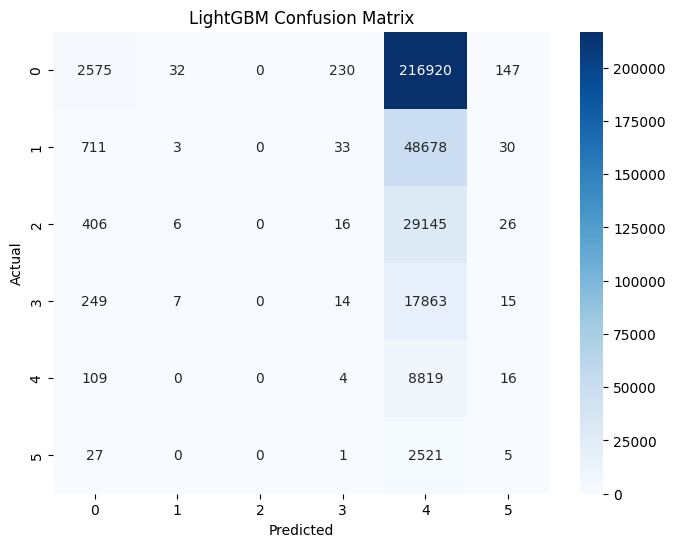

In [ ]:
print("\n📈 LightGBM Performance:")
print(classification_report(y_val, y_pred_lgbm))

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_val, y_pred_lgbm), annot=True, fmt='d', cmap='Blues')
plt.title("LightGBM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
clf_rf = RandomForestClassifier(
    n_estimators=50,        # fewer trees (default=100). You can try 50–100
    max_depth=20,           # limit depth to avoid huge trees
    min_samples_split=10,   # make trees less complex
    min_samples_leaf=4,     
    max_features='sqrt',    # faster, often good
    random_state=42,
    n_jobs=-1,              # use all CPU cores!
    verbose=1
)

clf_rf.fit(X_train_res, y_train_res)

y_pred_rf = clf_rf.predict(X_val)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.5s finished



📈 Random Forest Performance:
              precision    recall  f1-score   support

           0       0.67      0.97      0.79    219904
           1       0.13      0.00      0.00     49455
           2       0.08      0.02      0.03     29599
           3       0.10      0.00      0.00     18148
           4       0.00      0.00      0.00      8948
           5       0.00      0.00      0.00      2554

    accuracy                           0.65    328608
   macro avg       0.16      0.17      0.14    328608
weighted avg       0.48      0.65      0.53    328608



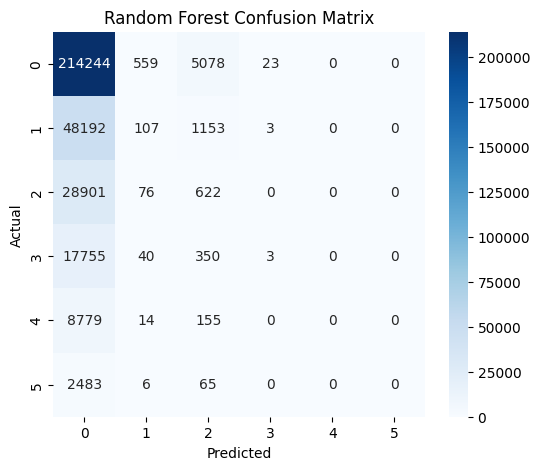

In [ ]:
print("\n📈 Random Forest Performance:")
print(classification_report(y_val, y_pred_rf))

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_val, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()